In [64]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [65]:
from model import EmotionClassifier

model = EmotionClassifier()
model.load_state_dict(torch.load('best_RAF.pth', map_location=device))
model.eval()  

EmotionClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features

In [66]:
# img_path = 'dataset/vali/img000_surprise.jpg'
# img_path = 'dataset/vali/img387_happiness.jpg'
img_path = 'archive/RAF-DB/train/train_00004_aligned_happiness.jpg'
# img_path = 'archive/RAF-DB/test/test_0001_aligned_sadness.jpg'
img = Image.open(img_path)

def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess(img).unsqueeze(0)  
    return img

img_tensor = preprocess_image(img_path)
logits = model(img_tensor)
probabilities = F.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
predicted_class.item()

0

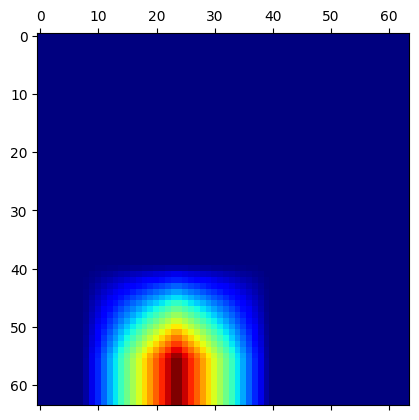

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


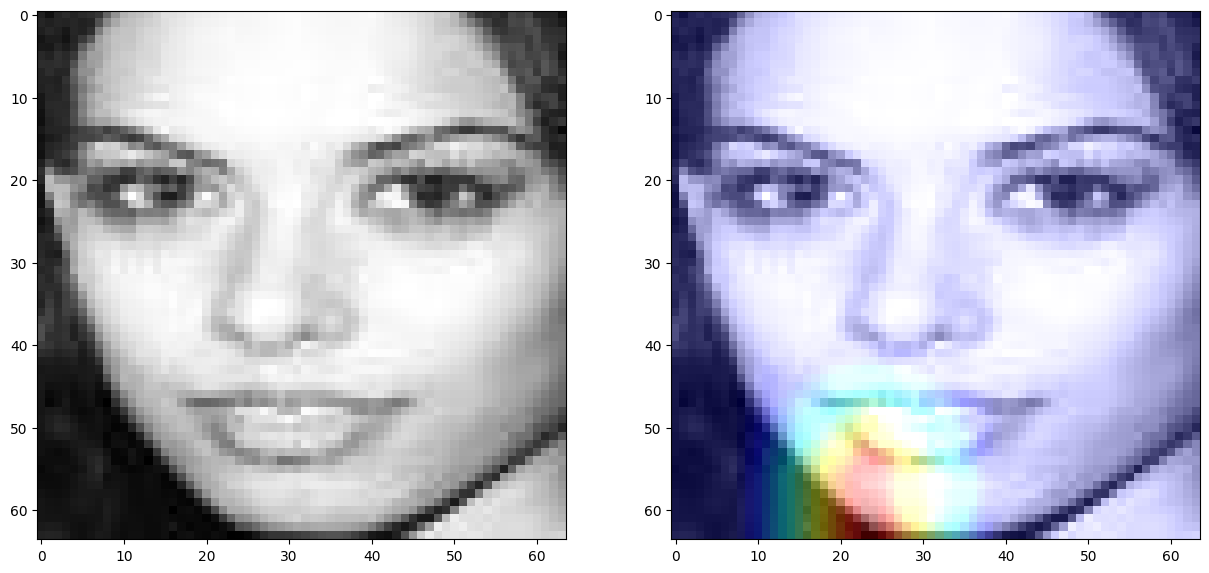

In [71]:
class Hook():
    ''' 
    A simple hook class that returns the input and output of a layer during forward and backward pass
    '''
    def __init__(self):
        self.hook_forward = None
        self.hook_backward = None
        self.forward_out = None
        self.backward_out = None

    def hook_fn_forward(self, module, input, output):
        self.forward_out = output

    def hook_fn_backward(self, module, grad_input, grad_output):
        self.backward_out = grad_output[0] 

    def register_hook(self, module):
        self.hook_forward = module.register_forward_hook(self.hook_fn_forward)
        self.hook_backward = module.register_full_backward_hook(self.hook_fn_backward)

    def unregister_hook(self):
        self.hook_forward.remove()
        self.hook_backward.remove()

final_layer = model.conv5
hook = Hook()
hook.register_hook(final_layer)

logits = model(img_tensor)

predicted_class_idx = predicted_class.item()

one_hot_output = torch.FloatTensor(1, probabilities.shape[1]).zero_()
one_hot_output[0][predicted_class_idx] = 1
logits.backward(one_hot_output, retain_graph=True)

gradients = hook.backward_out
feature_maps = hook.forward_out

hook.unregister_hook()

weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
cam = torch.sum(weights * feature_maps, dim=1, keepdim=True)
cam = cam.clamp(min=0).squeeze() 

cam -= cam.min()
cam /= cam.max()
cam = cam.cpu().detach().numpy()
cam = cv2.resize(cam, (64, 64))

plt.matshow(cam, cmap='jet')
plt.show()

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
superimposed_img = heatmap * 0.4 + np.float32(img) / 255
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.show()